In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules_enh.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [5]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#labelled_enh.head(32)

In [6]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#unlabelled_enh.head(32)

In [ ]:
len(labelled), len(labelled_enh)

In [15]:
from models import SKModel, partition_data

#data_df = labelled[labelled.type == '1JHC'].head(10)
data_df = labelled_enh.head(16)
train_df, valid_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df#.copy()
        
model = SKModel(molecules=molecules,
                structures=structures)
input_df, numeric_df, output_df = model.setup_data(train_df, train_df)
None

['atom0_x',
 'atom0_y',
 'atom0_z',
 'atom0_x_mean',
 'atom0_y_mean',
 'atom0_z_mean',
 'atomN_x',
 'atomN_y',
 'atomN_z',
 'atomN_x_mean',
 'atomN_y_mean',
 'atomN_z_mean',
 'atom1_x',
 'atom1_y',
 'atom1_z',
 'atom1_x_mean',
 'atom1_y_mean',
 'atom1_z_mean',
 'atom2_x',
 'atom2_y',
 'atom2_z',
 'atom2_x_mean',
 'atom2_y_mean',
 'atom2_z_mean',
 'atom3_x',
 'atom3_y',
 'atom3_z',
 'atom3_x_mean',
 'atom3_y_mean',
 'atom3_z_mean',
 'atom0_dir_x',
 'atom0_dir_y',
 'atom0_dir_z',
 'atomN_dir_x',
 'atomN_dir_y',
 'atomN_dir_z']


In [13]:
model.structures.columns

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z', 'x_mean',
       'y_mean', 'z_mean', 'dist_to_mean'],
      dtype='object')

In [ ]:
list(input_df.columns)

In [ ]:
list(numeric_df.columns)

In [50]:
unlabelled_enh['type'].iloc[0]

'2JHC'

In [ ]:
numeric_df.head(60)

In [ ]:
list(zip(input_df.columns, input_df.loc[14], input_df.loc[15]))

In [ ]:
import itertools

In [16]:
lgb_args = dict(n_jobs=8,
                max_depth=16,
                boosting_type='gbdt',
                num_leaves=65536, #128,
                min_child_samples=20,
                min_data_in_leaf=100,
                learning_rate=0.1,
                n_estimators=1000,
                reg_alpha=0.1,
                reg_lambda=0.3,
                bagging_fraction = 0.9,
                bagging_freq = 5,
                num_iterations=300)

Training 25000 samples for 1JHC
  Setting up data
  Fitting model


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



  Setting up data
  Fitting model
  Evaluating model
1JHC score: 0.7870531690997646 (trained on 25000 elements)


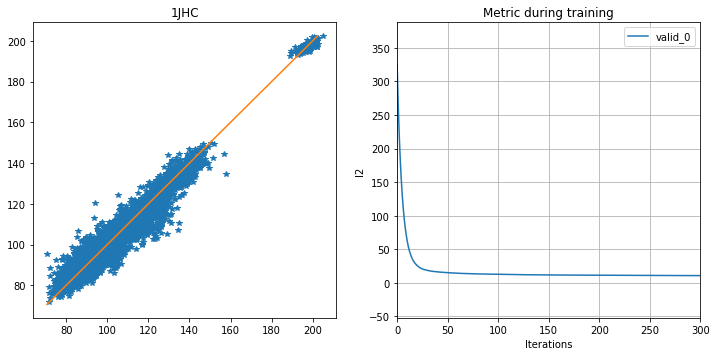

In [51]:
from models import LGBModel
from models import partition_data

coupling_types = sorted(labelled_enh.type.unique())[0:1]
models = {}
def test(data, count=5000):
    global model
    
    plt.figure(figsize=(25, 25))
    for i, t in enumerate(coupling_types, 1):    
        data_df = data[data.type == t].head(count)

        train_df, valid_df, test_df = partition_data(data_df)
        
        if len(train_df) < 10 or len(test_df) < 10:
            continue
            
        print(f'Training {len(train_df)} samples for {t}')

        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         lgb_args)
        models[t] = model

        model.fit(train_df, train_df, valid_df, valid_df)
        output, score = model.evaluate(test_df, test_df)
        
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')
        plt.subplot(4, 4, 2 * i - 1)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())
        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
        
        ax = plt.subplot(4, 4, 2 * i)
        model.plot_metric(ax=ax)
    plt.show()
        
test(labelled_enh, 50000)


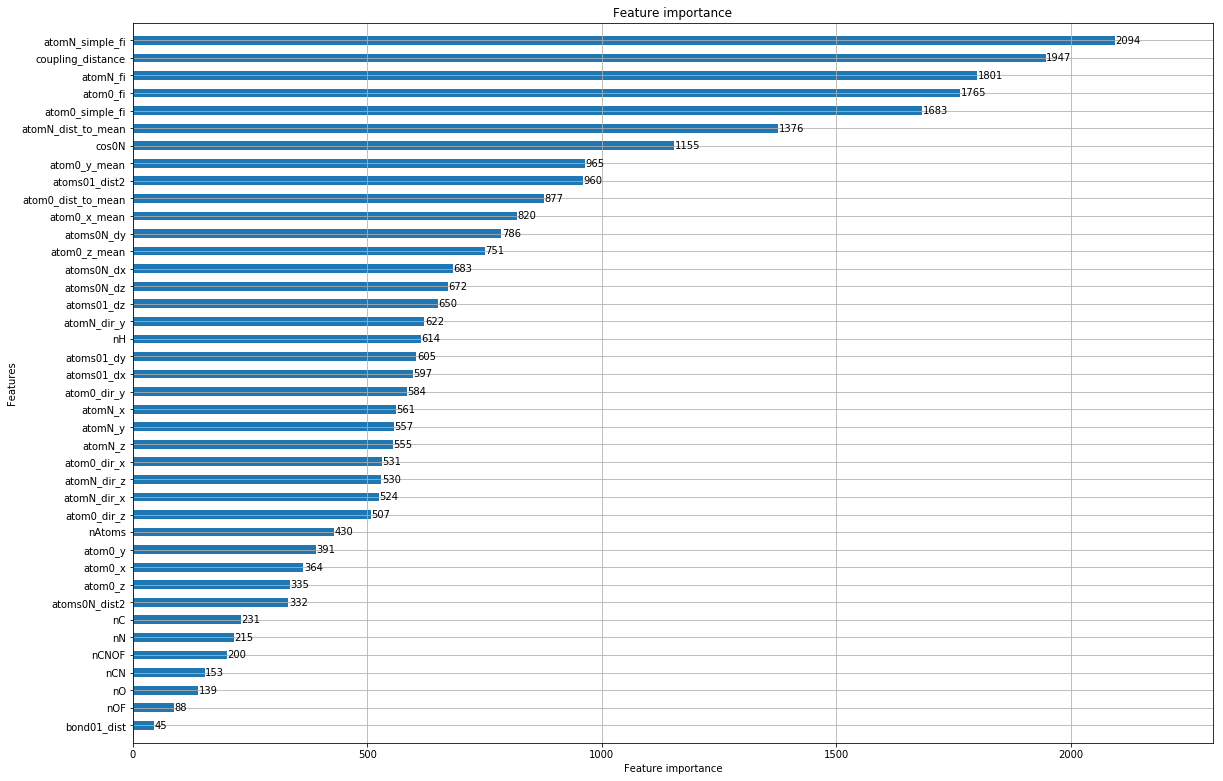

In [52]:
from models import LGBModel
fig = plt.figure(figsize=(15, 10))
model.plot_importance(ax=fig.add_axes([0, 0, 1, 1]), height=0.5)
plt.show()

In [53]:
model.last_numeric_input_df[['atoms23_dist']].head()

KeyError: "None of [Index(['atoms23_dist'], dtype='object')] are in the [columns]"

In [54]:
list(model.last_numeric_input_df.columns)

['nC',
 'nF',
 'nH',
 'nN',
 'nO',
 'nCNOF',
 'nCN',
 'nOF',
 'nAtoms',
 'coupling_distance',
 'coupling_1JHC',
 'atom0_F',
 'atom0_O',
 'atom0_C',
 'atom0_N',
 'atom0_H',
 'atom0_weight',
 'ai',
 'atom0_x',
 'atom0_y',
 'atom0_z',
 'atom0_x_mean',
 'atom0_y_mean',
 'atom0_z_mean',
 'atom0_dist_to_mean',
 'atom0_fi',
 'atom0_simple_fi',
 'atomN_F',
 'atomN_O',
 'atomN_C',
 'atomN_N',
 'atomN_H',
 'atomN_weight',
 'atomN_x',
 'atomN_y',
 'atomN_z',
 'atomN_x_mean',
 'atomN_y_mean',
 'atomN_z_mean',
 'atomN_dist_to_mean',
 'atomN_fi',
 'atomN_simple_fi',
 'atom1_F',
 'atom1_O',
 'atom1_C',
 'atom1_N',
 'atom1_H',
 'atom1_weight',
 'atom1_x',
 'atom1_y',
 'atom1_z',
 'atom1_x_mean',
 'atom1_y_mean',
 'atom1_z_mean',
 'atom1_dist_to_mean',
 'atom1_fi',
 'atom1_simple_fi',
 'bond01_dist',
 'bond01_dist2',
 'bond01_valency',
 'bond01_strength',
 'bond01_force',
 'bond01_cos',
 'bond01_cos2',
 'bond01_sin2',
 'atom0_dir_x',
 'atom0_dir_y',
 'atom0_dir_z',
 'atomN_dir_x',
 'atomN_dir_y',
 'ato

In [ ]:
from models import LGBModel

def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         lgb_args)
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

models = train(labelled_enh)

In [ ]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#%prun -s cumulative f(unlabelled.head(10000))
prediction = predict(unlabelled_enh, models)

In [ ]:
prediction.head()

In [ ]:
prediction.to_csv('../data/pred.csv',index=False)